# ResNet
## Reference
paper
1. [Deep Residual Learning for Image Recognition](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf)
2. [Identity Mappings in Deep Residual Networks](https://arxiv.org/pdf/1603.05027.pdf)

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

### Architecture
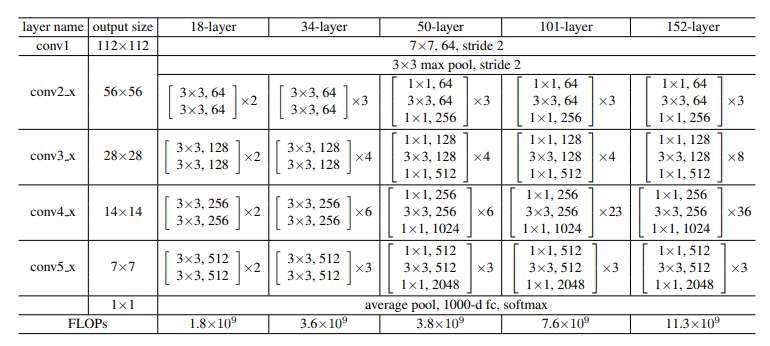

### Building block
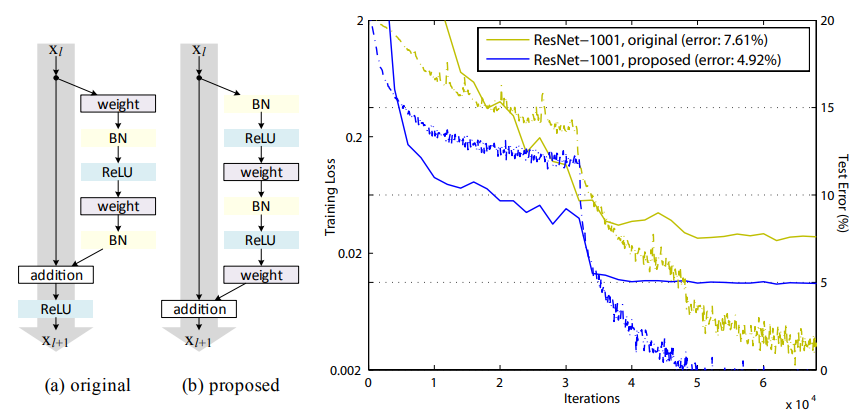

In [2]:
def block(input_tensor, n_filter, reduction=False):
  if reduction:
    stride = 2
  else:
    stride = 1
  # 1st 3x3 conv block
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=n_filter, kernel_size=3, strides=stride, padding='same')(x)

  # 2nd 3x3 conv block
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=n_filter, kernel_size=3, strides=1, padding='same')(x)

  # skip connection
  if reduction:
    input_tensor = layers.Conv2D(filters=n_filter, kernel_size=1, strides=stride, padding='same')(input_tensor)
  x = layers.add([x, input_tensor])
  return x

### 18 layer net

In [3]:
def resnet18(X):
  # 1st stage
  x = layers.ZeroPadding2D(padding=(3, 3))(X)
  x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)
  
  # 2nd stage
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)
  x = block(x, 64)
  x = block(x, 64)

  # 3rd stage
  x = block(x, 128, True)
  x = block(x, 128)

  # 4th stage
  x = block(x, 256, True)
  x = block(x, 256)

  # 5th stage
  x = block(x, 512, True)
  x = block(x, 512)

  # network head
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=100, activation='softmax')(x)
  return x

In [4]:
inputs_ = layers.Input(shape=(224, 224, 3))
resnet = resnet18(inputs_)
model = models.Model(inputs_, resnet)

In [5]:
model.build(input_shape=(224, 224, 3))

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 64)   0           conv2d[0][0]                     
______________________________________________________________________________________________

## Deeper network
### Identity block
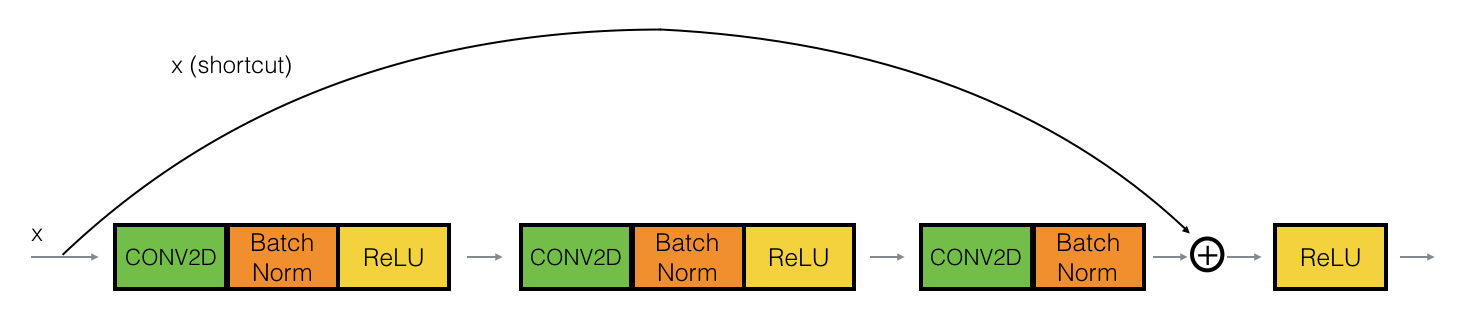

In [16]:
def idnetity_block(input_tensor, n_filter: list):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  x = layers.add([x, input_tensor])
  return x

### Conv block
This is applied when dimension is increased
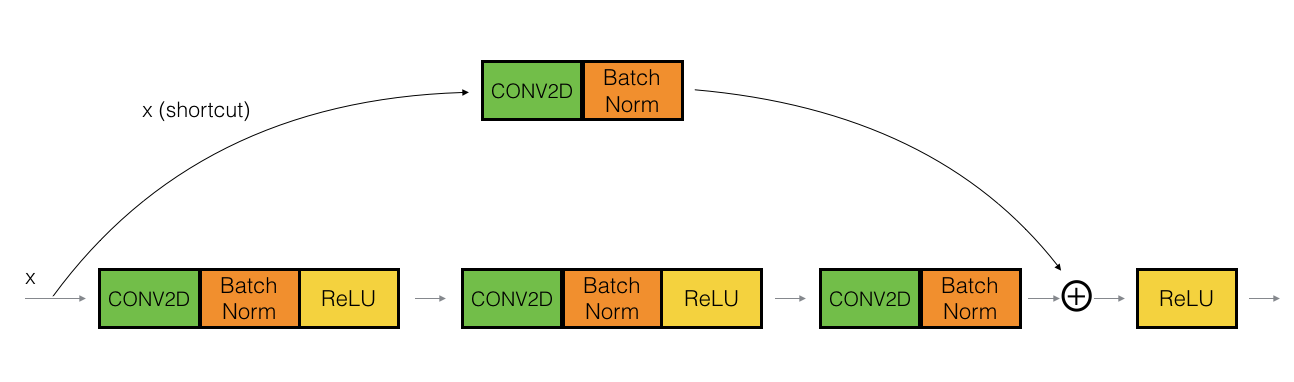

In [17]:
def conv_block(input_tensor, n_filter):
  F1, F2, F3 = n_filter
  # 1x1 conv layer
  x = layers.BatchNormalization()(input_tensor)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F1, kernel_size=(1, 1), strides=2, padding='valid')(x)

  # 3x3 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F2, kernel_size=(3, 3), strides=1, padding='same')(x)

  # 1x1 conv layer
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=1, padding='valid')(x)

  # shortcut connection
  skip = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=2, padding='valid')(input_tensor)
  x = layers.add([x, skip])

  return x

### 101 layer net

In [20]:
def resnet101(X):
  # 1st stage
  x = layers.ZeroPadding2D(padding=(3, 3))(X)
  x = layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(2, 2), padding='valid')(x)

  # 2nd stage
  x = layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x) # (55, 55, 64)
  x = conv_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])
  x = idnetity_block(x, [64, 64, 256])

  # 3rd stage
  x = conv_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])
  x = idnetity_block(x, [128, 128, 512])

  # 4th stage
  x = conv_block(x, [256, 256, 1024])
  for i in range(22):
    x = idnetity_block(x, [256, 256, 1024])

  # 5th stage
  x = conv_block(x, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])
  x = idnetity_block(x, [512, 512, 2048])

  # network head
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(units=1000, activation='softmax')(x)
  return x  